In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import torch
from tqdm import tqdm
from random import random
import matplotlib.colors as mcolors
import matplotlib.cm as cm

#sns darkgrid
sns.set_style("darkgrid")

%matplotlib inline
%cd /net/pulsar/home/koes/jok120/openfold


# LABEL_ENERGIES_PATH = '~/openfold/jk_research/evaluations/230420/230428_evaluationset_energies5.csv'
# DIRECTORIES_TO_LOAD_EVAL_DATA_FROM = ["out/evaluation/230420", "out/evaluation/230503", "out/evaluation/230507"]
DIRECTORIES_TO_LOAD_EVAL_DATA_FROM = ["out/evaluation/230607"]
CADAA_SCORES_PATH = 'jk_research/evaluations/230607/cadaa_scores.csv'
# MOLPROBITY_RAW_OUTPUT_DIR = 'jk_research/evaluations/230507/molpro'
MOLPROBITY_RAW_OUTPUT_DIR = '~/tmp/molpro'



/net/pulsar/home/koes/jok120/openfold


# Create DataFrames

## Create the model path dataframe `model_df`

In [2]:
def get_model_names_and_paths(basedir):
    """Get the model names and paths to the model directories."""
    model_names = os.listdir(basedir)
    model_paths = [f"{basedir}/{model_name}" for model_name in model_names]
    return model_names, model_paths

model_names, model_paths = [], []

for path in DIRECTORIES_TO_LOAD_EVAL_DATA_FROM:
    model_names2, model_paths2 = get_model_names_and_paths(path)
    model_names += model_names2
    model_paths += model_paths2


df_dict = {"model": [], "eval_path": []}

for model_name, model_path in zip(model_names, model_paths):
    df_dict["model"].append(model_name)
    df_dict["eval_path"].append(model_path)

model_df = pd.DataFrame(df_dict)


def add_test_and_val_results_path(row):
    eval_path = row["eval_path"]
    row["test_results_path"] = f"{eval_path}/test_results.csv"
    row["val_results_path"] = f"{eval_path}/val_results.csv"
    return row

model_df = model_df.apply(add_test_and_val_results_path, axis=1)


model_df

,model,eval_path,test_results_path,val_results_path
0,30kpure_scnmin_omm_00b_eval_s1224,out/evaluation/230607/30kpure_scnmin_omm_00b_e...,out/evaluation/230607/30kpure_scnmin_omm_00b_e...,out/evaluation/230607/30kpure_scnmin_omm_00b_e...
1,newbaseline_scnmin_noomm_00_eval_s958,out/evaluation/230607/newbaseline_scnmin_noomm...,out/evaluation/230607/newbaseline_scnmin_noomm...,out/evaluation/230607/newbaseline_scnmin_noomm...


## Evaluation protein energy dataframe `label_energy_df`

In [3]:
def get_label_energy_df():
    label_energy_df = pd.read_csv(LABEL_ENERGIES_PATH)
    # Rename pdbid_chainid to protein_name
    label_energy_df = label_energy_df.rename(columns={"pdbid_chainid": "protein_name"})
    # Drop the columns with the namd pdbid and chain_id
    label_energy_df = label_energy_df.drop(columns=["pdbid", "chain_id"])
    # Split into two dataframes for min and unmin
    label_energy_df_min = label_energy_df[label_energy_df["min_or_unmin"] == "min"]
    label_energy_df_unmin = label_energy_df[label_energy_df["min_or_unmin"] == "unmin"]
    # Drop the min_or_unmin column
    label_energy_df_min = label_energy_df_min.drop(columns=["min_or_unmin"])
    label_energy_df_unmin = label_energy_df_unmin.drop(columns=["min_or_unmin"])
    # Join the two dataframes on protein_name, appending _min and _unmin to only the column names containing "energy"
    label_energy_df = label_energy_df_min.merge(label_energy_df_unmin, on="protein_name", suffixes=["_min", "_unmin"])
    # Drop the dataset_unmin column and rename the dataset_min column to dataset
    label_energy_df = label_energy_df.drop(columns=["dataset_unmin"])
    label_energy_df = label_energy_df.rename(columns={"dataset_min": "dataset"})
    # Set protein_name as the index
    label_energy_df = label_energy_df.set_index("protein_name")
    # compute delta scn energy and delta openmm energy for min and unmin
    # label_energy_df["delta_scn_energy"] = label_energy_df["scn_energy_min"] - label_energy_df["scn_energy_unmin"]
    label_energy_df["delta_fastbuild_energy_unmin2min"] = label_energy_df["fastbuild_energy_min"] - label_energy_df["fastbuild_energy_unmin"]

    
    return label_energy_df

def add_energy_diff_columns(my_df):
    """Add columns to the dataframe that represent the difference between the predicted energy and the label energy in an unminimized and minimized state."""
    my_df["delta_energy_to_unmin_xtal"] = my_df["openmm_added_h_energy"] - my_df["openmm_pure_energy_unmin"]
    return my_df

In [ ]:
# Prepare the label_energy_df
label_energy_df = get_label_energy_df()
label_energy_df[label_energy_df["delta_fastbuild_energy_unmin2min"] > 0]
# drop protein_name 7qss_A which has a positive delta_fastbuild_energy_unmin2min
label_energy_df = label_energy_df.drop(index="7qss_A")
# save dataframe as a work in progress
label_energy_df.to_csv("/net/pulsar/home/koes/jok120/openfold/jk_research/evaluations/230607/label_energy_df.csv")
label_energy_df

## Make example baseline and comparison dataframes

In [4]:

baseline_name = "newbaseline_scnmin_noomm_00_eval_s958"
comparison_name = "30kpure_scnmin_omm_00b_eval_s1224"
baseline_sft = model_df[model_df["model"] == baseline_name].head(1)
comparison_model = model_df[model_df["model"] == comparison_name].head(1)
baseline_test_results_test = pd.read_csv(baseline_sft["test_results_path"].item())
comparison_test_results_test = pd.read_csv(comparison_model["test_results_path"].item())
baseline_test_results_valid = pd.read_csv(baseline_sft["val_results_path"].item())
comparison_test_results_valid = pd.read_csv(comparison_model["val_results_path"].item())

# Merge the label_energy_df with the model performance dfs
# baseline_test_results = baseline_test_results.merge(label_energy_df, on='protein_name')
# comparison_test_results = comparison_test_results.merge(label_energy_df, on='protein_name')

# baseline_test_results = add_energy_diff_columns(baseline_test_results)
# comparison_test_results = add_energy_diff_columns(comparison_test_results)

In [5]:
comparison_test_results_test

,protein_name,distogram,experimentally_resolved,fape,plddt_loss,masked_msa,supervised_chi,violation,openmm_unscaled,openmm_scaled,...,gdtts_ca,gdtha_ca,rmsd_aa,gdcall_aa,tmscore_aa,tmscore_ca,drmsd_aa,lddt_aa,lddtquasi_aa,phase
0,7sjl_A,0.452895,0.0,0.900340,0.0,2.226814,0.430582,0.000000,0.642483,0.642483,...,0.307203,0.091102,11.049608,0.066310,0.705616,0.403993,11.186848,0.751011,0.752006,eval
1,7eym_A,0.389181,0.0,0.341756,0.0,1.203181,0.183272,0.000000,0.142288,0.142288,...,0.932292,0.799479,1.896220,0.773860,0.971759,0.934438,1.359521,0.858631,0.859194,eval
2,7acy_B,0.206290,0.0,0.709739,0.0,0.905700,0.281672,0.000000,-0.347738,-0.347738,...,0.661528,0.444370,7.278419,0.436219,0.922008,0.862329,3.774904,0.850915,0.851366,eval
3,7skc_A,0.812041,0.0,0.488320,0.0,0.983394,0.509579,0.000000,0.312485,0.312485,...,0.794118,0.558824,2.971503,0.468651,0.866094,0.580491,2.074559,0.660540,0.662547,eval
4,7spn_A,0.178182,0.0,0.466046,0.0,1.196828,0.246565,0.000043,1.000000,1.000000,...,0.935855,0.792763,1.832797,0.767187,0.990380,0.977217,1.350818,0.856388,0.856779,eval
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,7y6c_A,0.372362,0.0,0.405989,0.0,1.406388,0.361684,0.000000,0.011849,0.011849,...,0.922535,0.774648,2.195077,0.708535,0.955954,0.908473,1.757217,0.789600,0.790591,eval
89,7w1i_A,0.167115,0.0,0.409891,0.0,1.348913,0.196283,0.000000,0.006015,0.006015,...,0.961771,0.821932,1.269222,0.798402,0.995104,0.990581,1.015864,0.872569,0.872901,eval
90,7r74_B,0.407241,0.0,0.413553,0.0,1.537855,0.305145,0.000000,0.043946,0.043946,...,0.915254,0.802966,2.091820,0.742945,0.970657,0.938998,1.548027,0.841145,0.841699,eval
91,7qil_A,0.660481,0.0,0.646543,0.0,1.203455,0.595014,0.000000,0.620538,0.620538,...,0.812500,0.600000,2.606191,0.560332,0.955672,0.900090,1.970758,0.704958,0.705938,eval


### Add CADaa scores to the dataframes

In [6]:
### Add CADAA scores to the dataframe; this dataframe has one row per protein like the current dataframes, but its columns are the CADAA scores for each model.
cadaa_scores_df = pd.read_csv(CADAA_SCORES_PATH)
baseline_cadaa_scores = cadaa_scores_df[baseline_name]

# Add the CADAA scores to the baseline dataframe where the protein_name matches
baseline_test_results_test = baseline_test_results_test.merge(cadaa_scores_df[['protein_name', baseline_name]], on='protein_name')
baseline_test_results_valid = baseline_test_results_valid.merge(cadaa_scores_df[['protein_name', baseline_name]], on='protein_name')
# Rename the column from the baseline name to "cadaa_score"
baseline_test_results_test = baseline_test_results_test.rename(columns={baseline_name: "cadaa_score"})
baseline_test_results_valid = baseline_test_results_valid.rename(columns={baseline_name: "cadaa_score"})


# Add the CADAA scores to the comparison dataframe where the protein_name matches
comparison_test_results_test = comparison_test_results_test.merge(cadaa_scores_df[['protein_name', comparison_name]], on='protein_name')
comparison_test_results_valid = comparison_test_results_valid.merge(cadaa_scores_df[['protein_name', comparison_name]], on='protein_name')
# Rename the column from the comparison name to "cadaa_score"
comparison_test_results_test = comparison_test_results_test.rename(columns={comparison_name: "cadaa_score"})
comparison_test_results_valid = comparison_test_results_valid.rename(columns={comparison_name: "cadaa_score"})
comparison_test_results_test

,protein_name,distogram,experimentally_resolved,fape,plddt_loss,masked_msa,supervised_chi,violation,openmm_unscaled,openmm_scaled,...,gdtha_ca,rmsd_aa,gdcall_aa,tmscore_aa,tmscore_ca,drmsd_aa,lddt_aa,lddtquasi_aa,phase,cadaa_score
0,7sjl_A,0.452895,0.0,0.900340,0.0,2.226814,0.430582,0.000000,0.642483,0.642483,...,0.091102,11.049608,0.066310,0.705616,0.403993,11.186848,0.751011,0.752006,eval,0.687728
1,7eym_A,0.389181,0.0,0.341756,0.0,1.203181,0.183272,0.000000,0.142288,0.142288,...,0.799479,1.896220,0.773860,0.971759,0.934438,1.359521,0.858631,0.859194,eval,0.849550
2,7acy_B,0.206290,0.0,0.709739,0.0,0.905700,0.281672,0.000000,-0.347738,-0.347738,...,0.444370,7.278419,0.436219,0.922008,0.862329,3.774904,0.850915,0.851366,eval,0.802570
3,7skc_A,0.812041,0.0,0.488320,0.0,0.983394,0.509579,0.000000,0.312485,0.312485,...,0.558824,2.971503,0.468651,0.866094,0.580491,2.074559,0.660540,0.662547,eval,0.648740
4,7spn_A,0.178182,0.0,0.466046,0.0,1.196828,0.246565,0.000043,1.000000,1.000000,...,0.792763,1.832797,0.767187,0.990380,0.977217,1.350818,0.856388,0.856779,eval,0.801688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,7y6c_A,0.372362,0.0,0.405989,0.0,1.406388,0.361684,0.000000,0.011849,0.011849,...,0.774648,2.195077,0.708535,0.955954,0.908473,1.757217,0.789600,0.790591,eval,0.771591
89,7w1i_A,0.167115,0.0,0.409891,0.0,1.348913,0.196283,0.000000,0.006015,0.006015,...,0.821932,1.269222,0.798402,0.995104,0.990581,1.015864,0.872569,0.872901,eval,0.832990
90,7r74_B,0.407241,0.0,0.413553,0.0,1.537855,0.305145,0.000000,0.043946,0.043946,...,0.802966,2.091820,0.742945,0.970657,0.938998,1.548027,0.841145,0.841699,eval,0.787856
91,7qil_A,0.660481,0.0,0.646543,0.0,1.203455,0.595014,0.000000,0.620538,0.620538,...,0.600000,2.606191,0.560332,0.955672,0.900090,1.970758,0.704958,0.705938,eval,0.682284


### Add MolProbity Scores to the dataframe

In [7]:
# Add MolProbity scores to the dataframe; The molprobity dir has csvs for each model with the molprobity scores for each protein.
# Ignore the first line; the second line contains the column names
# The file is colon separated
# initial_training_molprobity_df = pd.read_csv(f"{MOLPROBITY_RAW_OUTPUT_DIR}/initial_training_eval_s0.out", skiprows=1, sep=":")
# initial_training_molprobity_df["protein_name"] = initial_training_molprobity_df["#pdbFileName"].str[10:-4]
# initial_training_molprobity_df = initial_training_molprobity_df.drop(columns=["#pdbFileName"])


baseline_molprobity_df = pd.read_csv(f"{MOLPROBITY_RAW_OUTPUT_DIR}/{baseline_name}.out", skiprows=1, sep=":")
baseline_molprobity_df["protein_name"] = baseline_molprobity_df["#pdbFileName"].str[10:-4]
baseline_molprobity_df = baseline_molprobity_df.drop(columns=["#pdbFileName"])

comparison_molprobity_df = pd.read_csv(f"{MOLPROBITY_RAW_OUTPUT_DIR}/{comparison_name}.out", skiprows=1, sep=":")
comparison_molprobity_df["protein_name"] = comparison_molprobity_df["#pdbFileName"].str[10:-4]
comparison_molprobity_df = comparison_molprobity_df.drop(columns=["#pdbFileName"])

# Compute percentRamaFavored = ramaFavored / numRama
baseline_molprobity_df["percentRamaFavored"] = baseline_molprobity_df["ramaFavored"] / baseline_molprobity_df["numRama"]
comparison_molprobity_df["percentRamaFavored"] = comparison_molprobity_df["ramaFavored"] / comparison_molprobity_df["numRama"]



In [8]:
comparison_molprobity_df[['protein_name']]

,protein_name
0,7l8n_A
1,7b7t_A
2,7dkk_A
3,7nf9_A
4,7atr_A
...,...
110,7y6c_A
111,7w1i_A
112,7r74_B
113,7qil_A


In [ ]:
# make a histogram for the initial_training_molprobity_df's MolProbity score
# initial_training_molprobity_df["MolProbityScore"].hist(bins='auto')

In [9]:
# Merge the molprobity dataframes with the model performance dfs
baseline_test_results_test = baseline_test_results_test.merge(baseline_molprobity_df[['protein_name', 'MolProbityScore', 'clashscore', 'percentRamaFavored']], on='protein_name')
baseline_test_results_valid = baseline_test_results_valid.merge(baseline_molprobity_df[['protein_name', 'MolProbityScore', 'clashscore', 'percentRamaFavored']], on='protein_name')
comparison_test_results_test = comparison_test_results_test.merge(comparison_molprobity_df[['protein_name', 'MolProbityScore', 'clashscore', 'percentRamaFavored']], on='protein_name')
comparison_test_results_valid = comparison_test_results_valid.merge(comparison_molprobity_df[['protein_name', 'MolProbityScore', 'clashscore', 'percentRamaFavored']], on='protein_name')

In [10]:
comparison_test_results_test[['protein_name', 'MolProbityScore', 'clashscore', 'percentRamaFavored']]

,protein_name,MolProbityScore,clashscore,percentRamaFavored
0,7sjl_A,2.639,30.66,0.844828
1,7eym_A,1.954,29.39,1.000000
2,7acy_B,1.839,11.76,0.962264
3,7skc_A,2.545,34.01,0.906250
4,7spn_A,2.152,25.80,0.962555
...,...,...,...,...
88,7y6c_A,1.948,28.97,0.985507
89,7w1i_A,2.037,24.92,0.971717
90,7r74_B,1.883,24.77,0.982759
91,7qil_A,2.566,22.50,0.956522


In [11]:
baseline_test_results_test[['protein_name', 'MolProbityScore', 'clashscore', 'percentRamaFavored']]

,protein_name,MolProbityScore,clashscore,percentRamaFavored
0,7ead_A,1.882,24.67,0.984962
1,7ead_A,1.882,24.67,0.984962
2,7mwr_A,1.665,14.44,0.990099
3,7mwr_A,1.549,10.74,0.995050
4,7mwr_A,1.665,14.44,0.990099
...,...,...,...,...
105,7opb_D,1.624,13.02,1.000000
106,7zc8_A,2.023,34.77,0.988235
107,7snc_A,2.302,20.41,0.916667
108,7eym_A,1.915,26.79,0.989362


### Correlation Analysis

In [12]:
# Compute the  correlation between the MolProbity scores and openmm
baseline_test_results_test[['MolProbityScore', 'openmm', 'lddt_aa', 'cadaa_score', 'clashscore', 'percentRamaFavored']].corr(method='pearson')

,MolProbityScore,openmm,lddt_aa,cadaa_score,clashscore,percentRamaFavored
MolProbityScore,1.000000,0.240797,-0.706300,-0.701217,0.830395,-0.716590
openmm,0.240797,1.000000,-0.310041,-0.321000,0.206004,-0.241545
lddt_aa,-0.706300,-0.310041,1.000000,0.986342,-0.626152,0.640211
cadaa_score,-0.701217,-0.321000,0.986342,1.000000,-0.629638,0.634650
clashscore,0.830395,0.206004,-0.626152,-0.629638,1.000000,-0.701897
percentRamaFavored,-0.716590,-0.241545,0.640211,0.634650,-0.701897,1.000000


In [13]:
comparison_test_results_test[['MolProbityScore', 'openmm', 'lddt_aa', 'cadaa_score', 'clashscore', 'percentRamaFavored']].corr(method='pearson')

,MolProbityScore,openmm,lddt_aa,cadaa_score,clashscore,percentRamaFavored
MolProbityScore,1.000000,0.155962,-0.645675,-0.642623,0.716830,-0.726638
openmm,0.155962,1.000000,-0.049294,-0.064455,0.091683,-0.093531
lddt_aa,-0.645675,-0.049294,1.000000,0.984840,-0.465516,0.602049
cadaa_score,-0.642623,-0.064455,0.984840,1.000000,-0.474982,0.588060
clashscore,0.716830,0.091683,-0.465516,-0.474982,1.000000,-0.499765
percentRamaFavored,-0.726638,-0.093531,0.602049,0.588060,-0.499765,1.000000


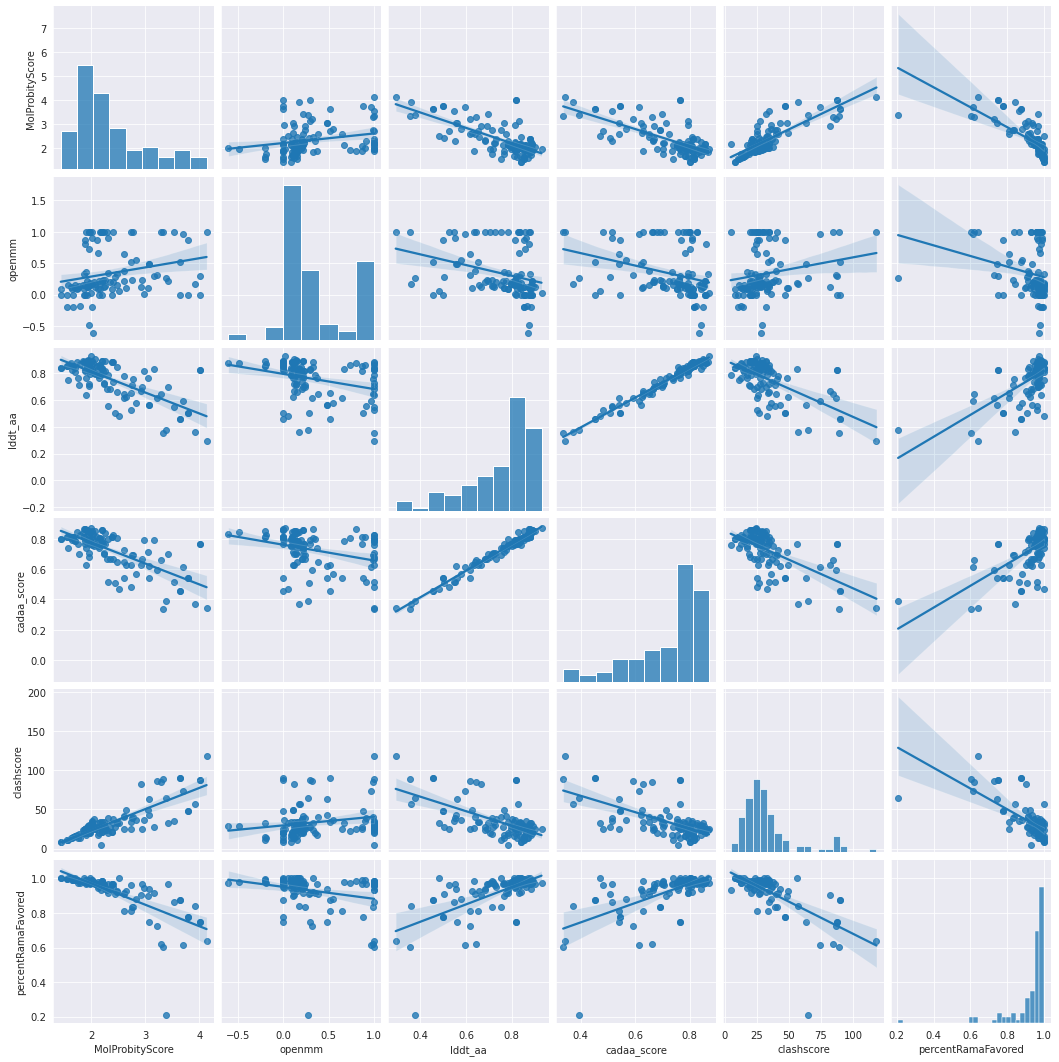

In [14]:
sns.pairplot(baseline_test_results_test[['MolProbityScore', 'openmm', 'lddt_aa', 'cadaa_score', 'clashscore', 'percentRamaFavored',]], kind="reg")

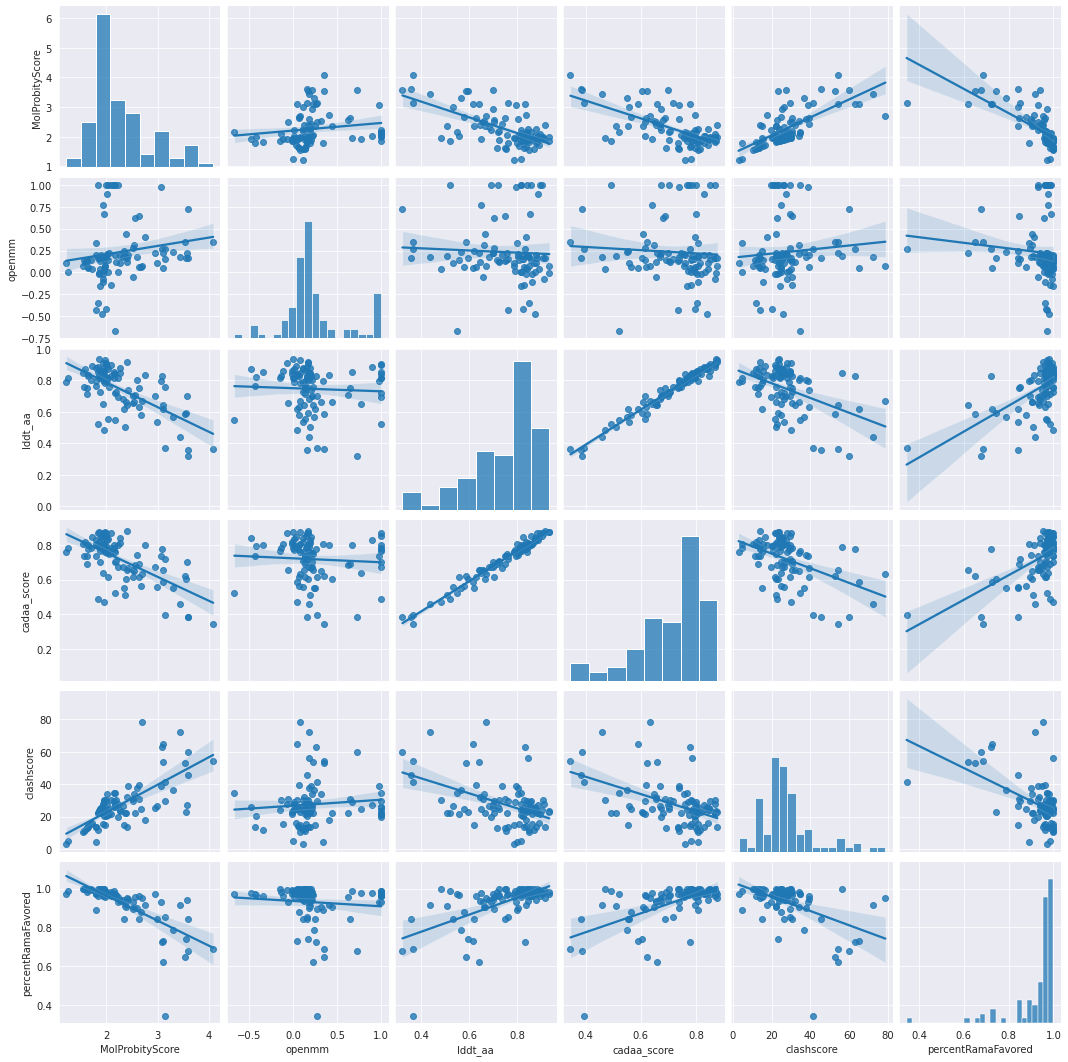

In [15]:
# Plot the correlation scatter plots for the correlation analyses above using seaborn
sns.pairplot(comparison_test_results_test[['MolProbityScore', 'openmm', 'lddt_aa', 'cadaa_score', 'clashscore', 'percentRamaFavored']], kind="reg")


#### High Accuracy Analysis
Is there correlation when the structure are very accurate?

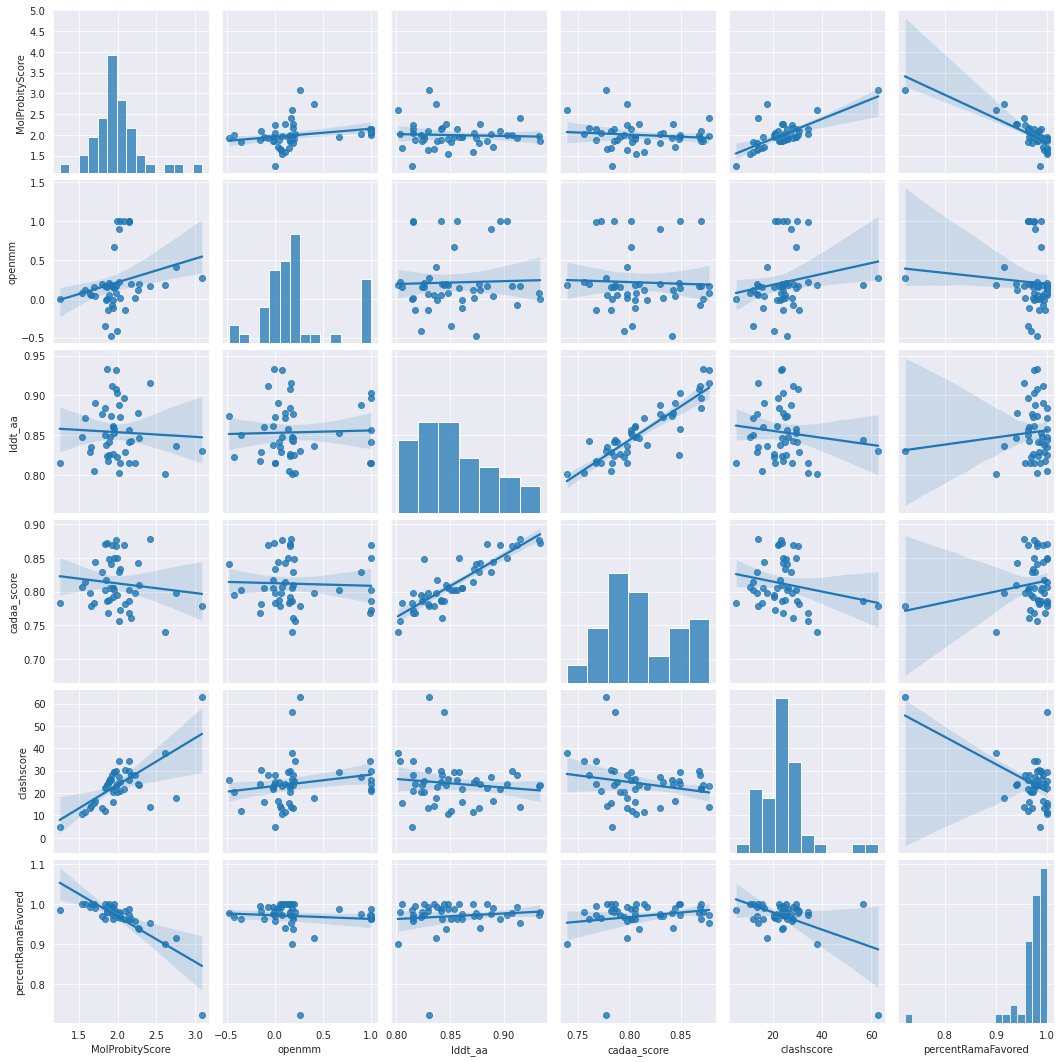

In [16]:
# comparison_test_results[comparison_test_results['lddt_aa'] > 0.85][['MolProbityScore', 'openmm', 'lddt_aa']].corr(method='pearson')
sns.pairplot(comparison_test_results_test[comparison_test_results_test['lddt_aa'] >= 0.8][['MolProbityScore', 'openmm', 'lddt_aa', 'cadaa_score', 'clashscore', 'percentRamaFavored']], kind="reg")


In [17]:
sns.pairplot(comparison_test_results[comparison_test_results['lddt_aa'] < 0.8][['MolProbityScore', 'openmm', 'lddt_aa', 'cadaa_score', 'clashscore', 'percentRamaFavored']], kind="reg")

NameError: name 'comparison_test_results' is not defined

In [ ]:
# comparison_test_results[comparison_test_results['lddt_aa'] <= 0.85][['MolProbityScore', 'openmm', 'lddt_aa']].corr(method='pearson')
sns.pairplot(comparison_test_results_test[comparison_test_results_test['lddt_aa'] >= 0.85][['MolProbityScore', 'openmm', 'lddt_aa', 'cadaa_score', 'clashscore', 'percentRamaFavored']], kind="reg")



## Measure delta delta energy to xtal

In [ ]:
i = 2
print('baseline:', baseline_test_results.iloc[i]['openmm_added_h_energy'], baseline_test_results.iloc[i]['openmm_pure_energy_unmin'])
print('comparison:', comparison_test_results.iloc[i]['openmm_added_h_energy'], comparison_test_results.iloc[i]['openmm_pure_energy_unmin'])
comparison_test_results['delta_delta_energy_to_xtal'] = comparison_test_results["delta_energy_to_unmin_xtal"] - baseline_test_results["delta_energy_to_unmin_xtal"]

# Make Scatterplots

## Function

In [20]:
# plt.ioff()
def make_accuracy_plot(dfx,
                       dfy,
                       dfx_name,
                       dfy_name,
                       dataset_split,
                       metric="gdcall_aa",
                       hue="",
                       hue_is_y=True,
                       hue_is_yraw=False,
                       use_log=False,
                       use_cube_root=False,
                       alpha=1,
                       size=3,
                       ax=None,
                       index=0,
                       save_prefix="",
                       fig=None,
                    #    label_energy_df=get_label_energy_df(),
                       scale_hue=1,
                       ):
    """Make a scatter plot with seaborn comparing methods dfx and dfy on metric.
    Each row of the dataframes correspond to a different protein. For each protein,
    plot a point on the scatter plot with x-value equal to the metric value for dfx
    and y-value equal to the metric value for dfy.
    First join the dataframes on the protein column using suffixes to rename duplicate cols,
    then plot the metric values for each method.
    """
    

    df = dfx.merge(dfy, on="protein_name", suffixes=(f"_{dfx_name}", f"_{dfy_name}"))

    if use_log:
        df[f"{metric}_{dfx_name}_log"] = np.log(df[f"{metric}_{dfx_name}"])
        df[f"{metric}_{dfy_name}_log"] = np.log(df[f"{metric}_{dfy_name}"])
        xmetric = f"{metric}_{dfx_name}_log"
        ymetric = f"{metric}_{dfy_name}_log"
        metric = f"{metric}_log"
    elif use_cube_root:
        df[f"{metric}_{dfx_name}_cube_root"] = np.cbrt(df[f"{metric}_{dfx_name}"])
        df[f"{metric}_{dfy_name}_cube_root"] = np.cbrt(df[f"{metric}_{dfy_name}"])
        xmetric = f"{metric}_{dfx_name}_cube_root"
        ymetric = f"{metric}_{dfy_name}_cube_root"
        metric = f"{metric}_cube_root"
    else:
        xmetric = f"{metric}_{dfx_name}"
        ymetric = f"{metric}_{dfy_name}"

    # determine the min and max values over the x and y axis to set the limits of the plot uniformly
    # However, add a buffer to the min and max values so that the points are not on the edge of the plot
    min_val = min(df[xmetric].min(), df[ymetric].min())
    max_val = max(df[xmetric].max(), df[ymetric].max())
    # Add a buffer to the min and max values
    buffer = 0.05 * (max_val - min_val)
    min_val -= buffer
    max_val += buffer
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Set the appropriate x and y axis limits using the fig and ax variables
    # Use the min and max values calculated above

    # make sure no limit is nan or inf
    if not np.isnan(min_val) and not np.isinf(min_val):
        ax.set_xlim(min_val, max_val)
        ax.set_ylim(min_val, max_val)
    
    # plot a dotted line y=x on the same figure without displaying it
    ax.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="black", alpha=0.5);


    # if hue is not empty, use it to color the points
    if hue:
        # Use coolwarm colormap, with negative values being red and positive values being blue
        if hue_is_yraw:
            name = hue
        elif hue_is_y:
            name = f"{hue}_{dfy_name}"
        else:
            name = f"{hue}_{dfx_name}"
        try:
            vals = df[name] / scale_hue
        except KeyError:
            print(f"{name} not found in df")
            print(df.columns)
            return
        if 'energy' in hue or 'openmm' in hue:
            vmin, vmax = vals.min(), vals.max()
            vcenter = 0
            if vmin > 0:
                vcenter = vmin + 1e-6

        else:
            vmin = 0
            vmax = 1
            vcenter = 0.5
        assert (vmin < vcenter < vmax), f"{name}: Must have vmin < vcenter < vmax, but got vmin: {vmin}, vcenter: {vcenter}, vmax: {vmax}"
        print(f"vmin: {vmin}, vmax: {vmax}, vcenter: {vcenter}")

        normalize = mcolors.TwoSlopeNorm(vcenter=vcenter, vmin=vmin, vmax=vmax)
        scalarmappaple = cm.ScalarMappable(norm=normalize, cmap='coolwarm' if vcenter == 0 else 'Blues')
        scalarmappaple.set_array(vals)
        plt.colorbar(scalarmappaple, label=name)


    if hue and hue_is_yraw:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=hue, ax=ax, alpha=alpha, palette='coolwarm' if vcenter == 0 else 'Blues', norm=normalize);
    elif hue and hue_is_y:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=f"{hue}_{dfy_name}", ax=ax, alpha=alpha, palette='coolwarm' if vcenter == 0 else 'Blues');
    elif hue and not hue_is_y:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, hue=f"{hue}_{dfx_name}", ax=ax, alpha=alpha);
    else:
        sns.scatterplot(data=df, x=xmetric, y=ymetric, ax=ax, alpha=alpha);


    # Get the mean values for each method
    dfx_mean = df[xmetric].mean()
    dfy_mean = df[ymetric].mean()

    # Set the position of the box
    ax.text(
        0.05,
        0.95,
        f"y mean: {dfy_mean:.3f}\nx mean: {dfx_mean:.3f}\ny-x: {dfy_mean - dfx_mean:.4f}\ny std: {df[ymetric].std():.2f}\nx std: {df[xmetric].std():.2f}",
        horizontalalignment="left",
        verticalalignment="top",
        transform=ax.transAxes,
        bbox=dict(boxstyle="square", facecolor="white", alpha=0.5),
    )

    plt.xlabel(f"{dfx_name}");
    plt.ylabel(f"{dfy_name}");
    plt.title(f"{metric} : {dataset_split}");

    ax.get_legend().remove()

    # Ensure a white background
    if fig:
        fig.patch.set_facecolor('white')

    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")
    

    

    # Return the plot
    return ax




In [21]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 110

## Sample plots

In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="lddt_aa",
hue="delta_delta_energy_to_xtal",
hue_is_yraw=True,
hue_is_y=True,
alpha=.9,
size=4)


vmin: -0.66968834400177, vmax: 1.0, vcenter: 0


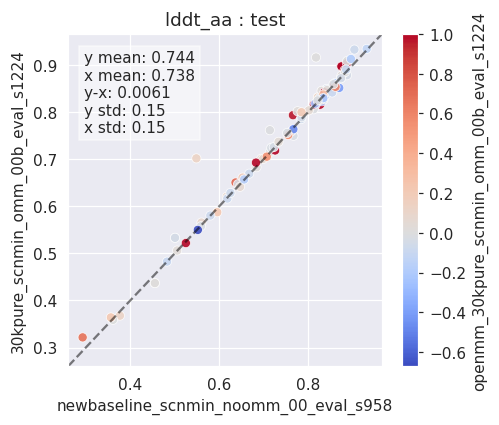

In [22]:
f = make_accuracy_plot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="lddt_aa",
hue="openmm",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: -0.2155752927064895, vmax: 1.0, vcenter: 0


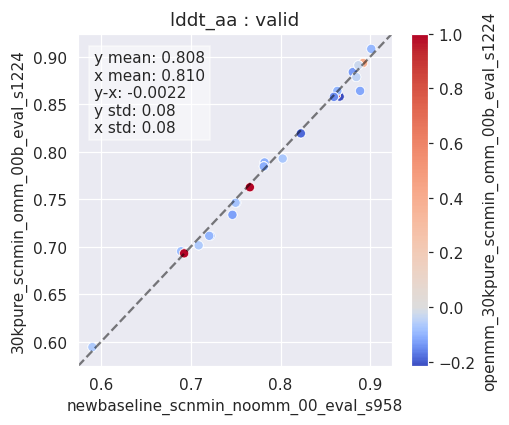

In [23]:
f = make_accuracy_plot(dfx=baseline_test_results_valid,
dfy=comparison_test_results_valid,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="lddt_aa",
hue="openmm",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: 0, vmax: 1, vcenter: 0.5


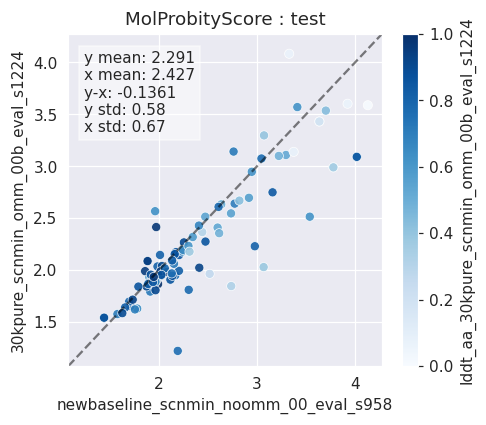

In [26]:
f = make_accuracy_plot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="MolProbityScore",
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: 0, vmax: 1, vcenter: 0.5


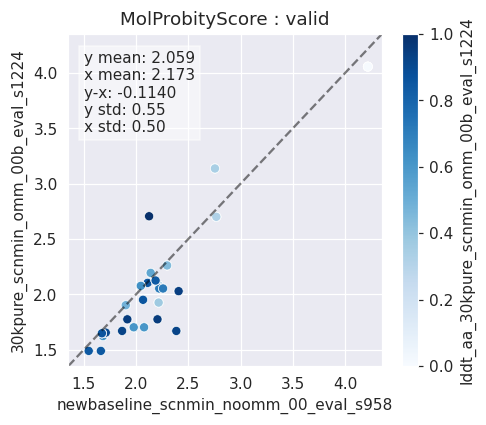

In [27]:
f = make_accuracy_plot(dfx=baseline_test_results_valid,
dfy=comparison_test_results_valid,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="MolProbityScore",
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: 0, vmax: 1, vcenter: 0.5


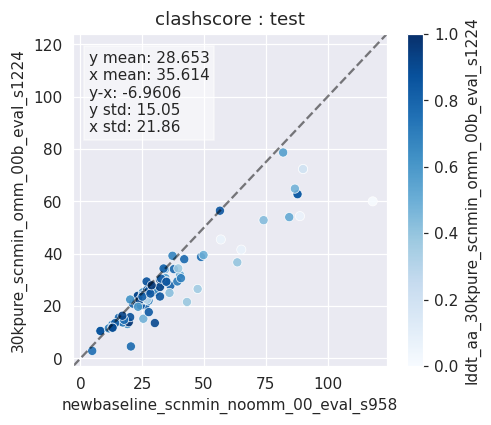

In [28]:
f = make_accuracy_plot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="clashscore",
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: -0.66968834400177, vmax: 1.0, vcenter: 0


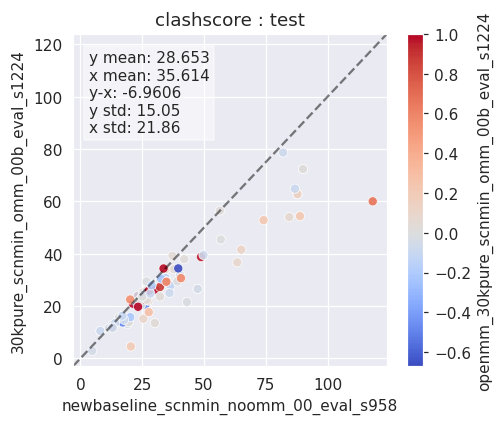

In [44]:
f = make_accuracy_plot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="clashscore",
hue="openmm",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: 0, vmax: 1, vcenter: 0.5


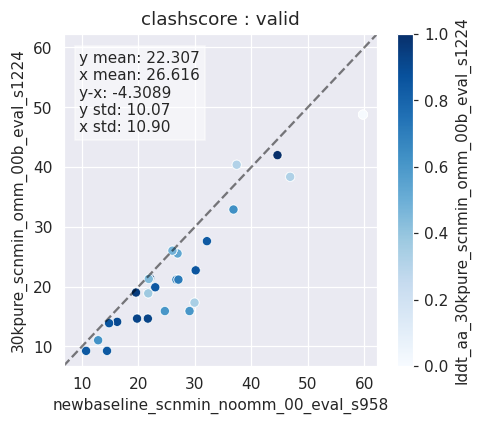

In [29]:
f = make_accuracy_plot(dfx=baseline_test_results_valid,
dfy=comparison_test_results_valid,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="clashscore",
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: 0, vmax: 1, vcenter: 0.5


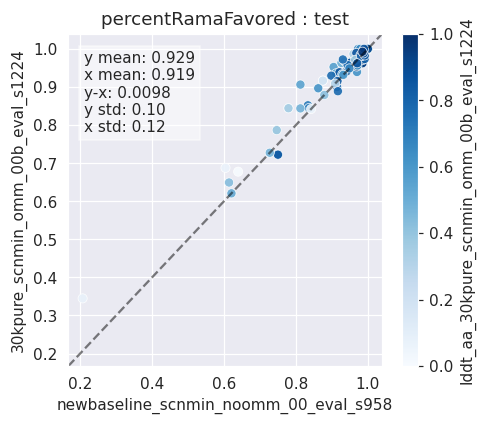

In [30]:
f = make_accuracy_plot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="percentRamaFavored",
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: 0, vmax: 1, vcenter: 0.5


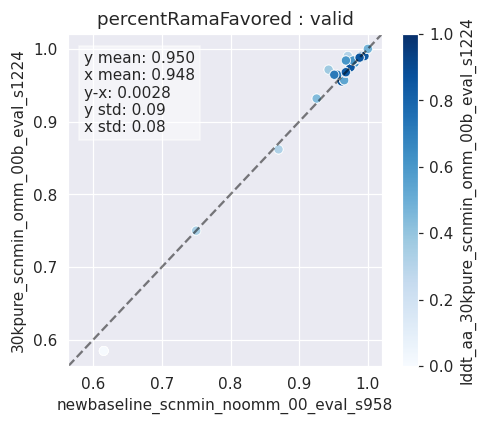

In [31]:
f = make_accuracy_plot(dfx=baseline_test_results_valid,
dfy=comparison_test_results_valid,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="percentRamaFavored",
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: 0, vmax: 1, vcenter: 0.5


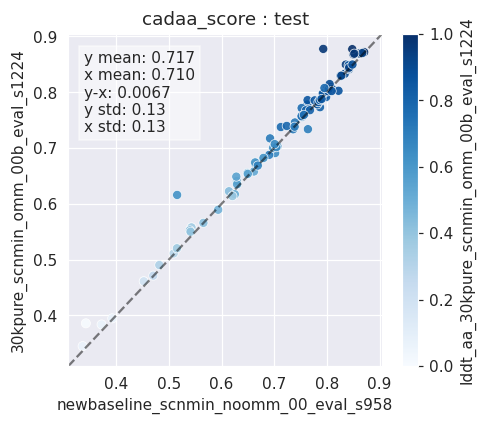

In [33]:
f = make_accuracy_plot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="cadaa_score",
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


vmin: 0, vmax: 1, vcenter: 0.5


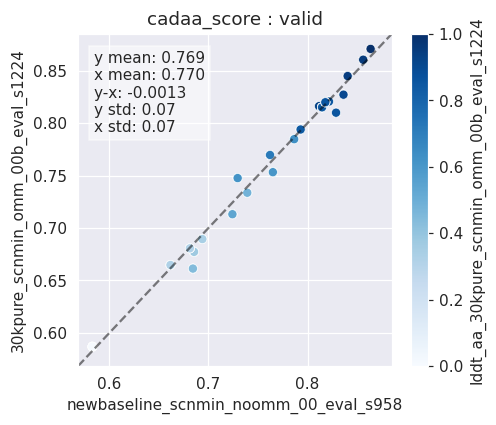

In [34]:
f = make_accuracy_plot(dfx=baseline_test_results_valid,
dfy=comparison_test_results_valid,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="cadaa_score",
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


<AxesSubplot:title={'center':'cadaa_score : test'}, xlabel='source', ylabel='cadaa_score'>

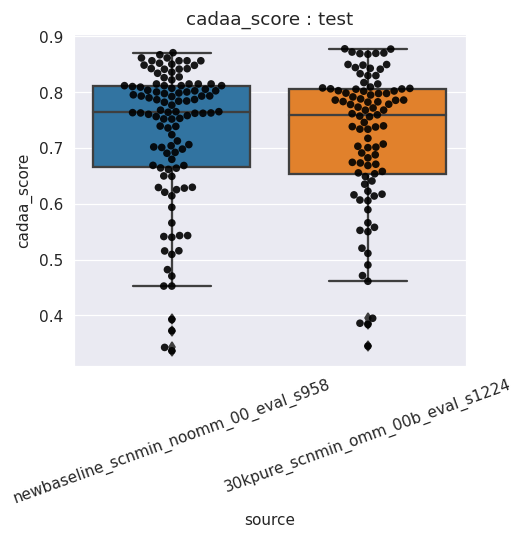

In [41]:
def make_barplot(dfx, dfy, dfx_name, dfy_name, metric, dataset_split, hue=None, hue_is_y=False, alpha=0.9, size=4, save_prefix=None, index=0, fliers=True):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(size*1.15, size));

    # Concatenate the two dataframes
    df = pd.concat([dfx, dfy])

    # Add a column to the dataframe to indicate the source of each row
    df["source"] = [dfx_name] * len(dfx) + [dfy_name] * len(dfy)

    # Plot the barplot
    sns.boxplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], ax=ax, showfliers=fliers);
    sns.swarmplot(data=df, x="source", y=metric, hue=hue, hue_order=["baseline", "comparison"], alpha=alpha, ax=ax, color='black');

    # Set the y axis label to be the metric
    plt.ylabel(metric);

    # Set the title of the plot to be the metric and the dataset split
    plt.title(f"{metric} : {dataset_split}");

    # Rotate the entire plot 
    plt.xticks(rotation=20);


    # Save the plot
    if save_prefix:
        plt.savefig(f"{save_prefix}{index}.png", dpi=300, bbox_inches="tight")

    # Return the plot
    return ax

make_barplot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="cadaa_score")

<AxesSubplot:title={'center':'cadaa_score : valid'}, xlabel='source', ylabel='cadaa_score'>

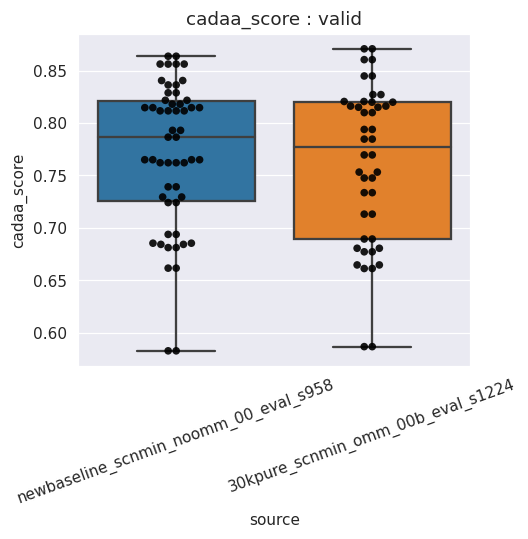

In [36]:
make_barplot(dfx=baseline_test_results_valid,
dfy=comparison_test_results_valid,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="cadaa_score")

<AxesSubplot:title={'center':'MolProbityScore : valid'}, xlabel='source', ylabel='MolProbityScore'>

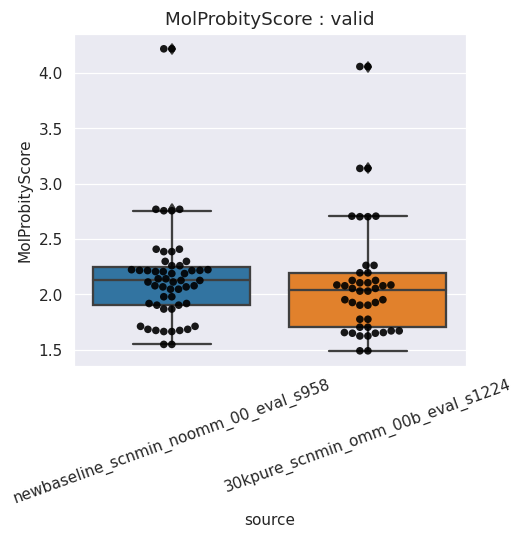

In [37]:
make_barplot(dfx=baseline_test_results_valid,
dfy=comparison_test_results_valid,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="MolProbityScore")

<AxesSubplot:title={'center':'MolProbityScore : test'}, xlabel='source', ylabel='MolProbityScore'>

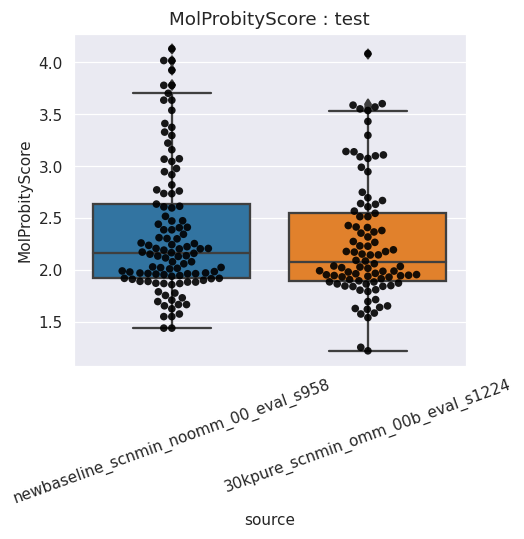

In [38]:
make_barplot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="MolProbityScore")

<AxesSubplot:title={'center':'clashscore : test'}, xlabel='source', ylabel='clashscore'>

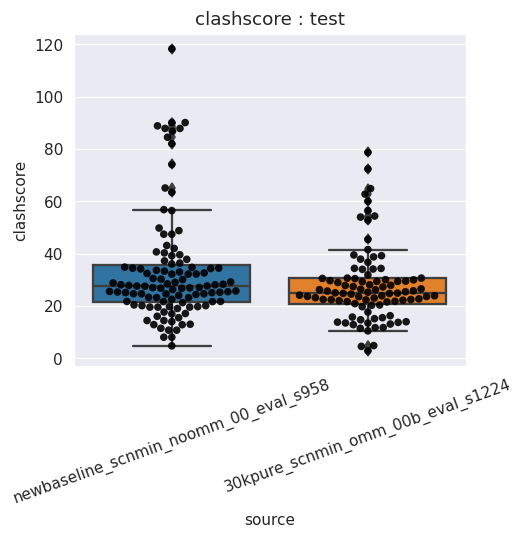

In [39]:
make_barplot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="clashscore")

/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 23.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/pulsar/home/koes/jok120/anaconda3/envs/sidechainnetv2/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 14.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:title={'center':'percentRamaFavored : test'}, xlabel='source', ylabel='percentRamaFavored'>

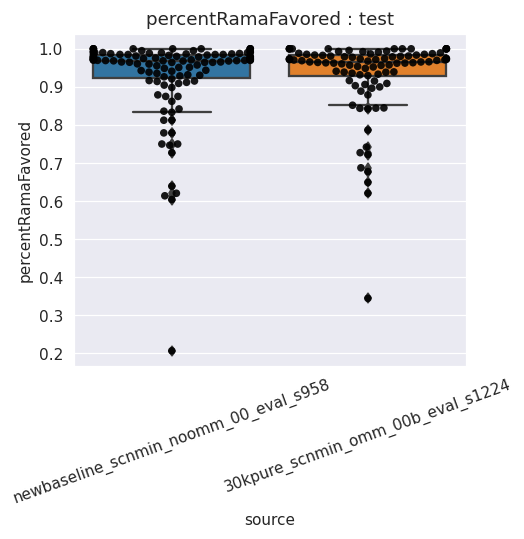

In [43]:
make_barplot(dfx=baseline_test_results_test,
dfy=comparison_test_results_test,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="percentRamaFavored")

In [ ]:
make_barplot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="MolProbityScore")

In [ ]:
make_barplot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="MolProbityScore")

In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="percentRamaFavored",
use_cube_root=False,
hue="openmm",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="clashscore",
use_cube_root=False,
hue="openmm",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="cadaa_score",
use_cube_root=False,
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="cadaa_score",
use_cube_root=False,
hue="openmm",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="MolProbityScore",
use_cube_root=False,
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="MolProbityScore",
use_cube_root=False,
hue="openmm",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="MolProbityScore",
use_cube_root=False,
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="MolProbityScore",
use_cube_root=False,
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='valid',
metric="MolProbityScore",
use_cube_root=False,
hue="openmm",
hue_is_yraw=False,
hue_is_y=True,
alpha=.8,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name=baseline_name,
dfy_name=comparison_name,
dataset_split='test',
metric="cadaa_score",
use_cube_root=False,
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.5,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s777",
dfy_name="xfer_scnmin_omm_06g19_eval_s777",
dataset_split='test',
metric="openmm",
use_cube_root=False,
hue="lddt_aa",
hue_is_yraw=False,
hue_is_y=True,
alpha=.9,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s777",
dfy_name="xfer_scnmin_omm_06g19_eval_s777",
dataset_split='test',
metric="rmsd_aa",
hue="delta_delta_energy_to_xtal",
hue_is_yraw=True,
hue_is_y=True,
alpha=.9,
size=4)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s777",
dfy_name="xfer_scnmin_omm_06g19_eval_s777",
dataset_split='test',
metric="tmscore_ca",
hue="delta_delta_energy_to_xtal",
hue_is_yraw=True,
hue_is_y=True,
alpha=.9,
size=4)


In [ ]:
baseline_sft = model_df[model_df["model"] == "initial_training_eval_s0"].head(1)
comparison_model = model_df[model_df["model"] == "xfer_scnmin_omm_04_eval_s1659"].head(1)
baseline_test_results = pd.read_csv(baseline_sft["test_results_path"].item())
comparison_test_results = pd.read_csv(comparison_model["test_results_path"].item())

In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='val',
metric="gdcall_aa",
hue="openmm",
alpha=.81,
size=5)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='val',
metric="lddt_ca",
hue="openmm",
alpha=.8,
size=5)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='val',
metric="tmscore_ca",
hue="openmm",
alpha=.8,
size=5)


In [ ]:
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='val',
metric="tmscore_aa",
hue="openmm",
alpha=.8,
size=5)


In [ ]:
# TODO FIX DATASET SPLIT!! not chainging
f = make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric="openmm",
hue="gdcall_aa",
alpha=.8,
size=5)


In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric="lddt_aa",
hue="openmm")


In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric="lddt_ca",
hue="openmm")


In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="baseline_scnmin_noomm_00_eval_s945",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric="rmsd_aa",
hue="openmm")


In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="initial_training_eval_s0",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric='openmm_scaled',
hue="gdcall_aa")

In [ ]:
make_accuracy_plot(dfx=baseline_test_results,
dfy=comparison_test_results,
dfx_name="initial_training_eval_s0",
dfy_name="xfer_scnmin_omm_04_eval_s1659",
dataset_split='test',
metric='openmm_raw_energy',
use_log=False,
use_cube_root=True,
hue="gdcall_aa",
size=3)

## All Plots

In [ ]:
example_results_df = model_df[model_df["model"] == "initial_training_eval_s0"].head(1)
example_results_df = pd.read_csv(example_results_df["test_results_path"].item())
example_results_df.head()

In [ ]:
# Use the function make_accuracy_plot to make a 3 x N grid of plots
# It should use all combinations of the following:
# - for the x axis (dfx), use the models 'initial_trainint_eval_s0', 'baseline_scnmin_noomm_00_eval_s945', and 'baseline_scnmin_noomm_00_eval_s3869'
# - for the y axis (dfy), use all of the other non-x axis models ('baseline_scnmin_omm_00c_eval_s1839', 'initial_training_eval_s0', 'xfer_scnmin_omm_01_eval_s3675', 'xfer_scnmin_omm_02_eval_s5087', 'xfer_scnmin_omm_03_eval_s2289', 'xfer_scnmin_omm_04_eval_s1659', 'xfer_scnmin_omm_05_eval_s1638')
# - for the metric, use all of the columns in the dataframe except protein_name and phase
# - for the hue, use gdcall_aa when the metric contains openmm, otherwise use openmm
# - for each combination of the above, read the csv corresponding to each models test_results_path and val_results_path
# - for each combination of the above, use the dataset_split according to if the test_results or val_reults were loaded

# X-axis: filter model names from model_df that don't include 'initial' or 'noommm'
dfx_names = sorted(
    model_df[model_df["model"].str.contains("initial|noomm")]["model"].unique().tolist())
dfx_names = ['initial_training_eval_s0', 'baseline_scnmin_noomm_00_eval_s777',  'baseline_scnmin_noomm_00_eval_s945', 'baseline_scnmin_noomm_00_eval_s3869',  ]
print(dfx_names)

# Y-axis: return models that are not in the x-axis
dfy_names = sorted(
    model_df[~model_df["model"].isin(dfx_names)]["model"].unique().tolist(), reverse=True)
print(dfy_names)

# Metric: return all columns except protein_name and phase from example_results_df
metrics = example_results_df.columns.tolist()
to_remove = [
    "protein_name", "phase", "plddt_loss", "experimentally_resolved", "unscaled_loss",
    "seq_length", "openmm_scaled", "loss", 'lddtquasi_aa','drmsd_ca','drmsd_aa',
]
for item in to_remove:
    metrics.remove(item)
print(metrics)


def get_df_from_name(name, set):
    this_df = model_df[model_df["model"] == name].head(1)
    if set == "test":
        this_df = pd.read_csv(this_df["test_results_path"].item())
    elif set == "val":
        this_df = pd.read_csv(this_df["val_results_path"].item())
    else:
        raise ValueError("set must be 'test' or 'val'")
    return this_df


def plot_arg_generator():
    for eval_set in ["test", "val"]:
        for dfx_name in dfx_names:
            for dfy_name in dfy_names:
                for metric in metrics:
                    if "openmm" in metric:
                        hue = "lddt_aa"
                    else:
                        hue = "openmm"
                    dfx = get_df_from_name(dfx_name, eval_set)
                    dfy = get_df_from_name(dfy_name, eval_set)
                    if "raw" in metric:
                        yield dfx, dfy, dfx_name, dfy_name, eval_set, metric, hue, True, False, False, True
                    else:
                        yield dfx, dfy, dfx_name, dfy_name, eval_set, metric, hue, True, False, False, False


In [ ]:
plt_args = list(plot_arg_generator())

In [ ]:
len(plt_args)

In [ ]:
%%capture
plots = []
outdir = "/net/pulsar/home/koes/jok120/openfold/jk_research/evaluations/230420/plots0425d/"
os.makedirs(outdir, exist_ok=True)
limit=3
for i, args in tqdm(enumerate(plt_args), total=len(plt_args)):
    p = make_accuracy_plot(
        *args,
        save_prefix=outdir,
        index=i,
        size=2,
        alpha=0.7);
    plots.append(p)
    if limit is not None and i > limit: break

    

In [ ]:
756/9

In [ ]:
L = 4
W = 3
n_plots = 12 #len(plots)

# Create a grid of L x W subfigures
fig, axes = plt.subplots(L, W, figsize=(16, 16), sharex=False, sharey=False)

for i in range(L):
    for j in range(W):
        index = i * W + j
        print(index)
        if index > n_plots - 1:
            break
        make_accuracy_plot(*plt_args[index], ax=axes[i, j], size=3)
        # fig_ij = plots[index]
        # Copy the content of the returned figure to the subfigure
        # axes[i, j].imshow(fig_ij.canvas.buffer_rgba())

# Adjust spacing between subfigures
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the grid of subfigures
plt.show()

# Distribution plots

In [ ]:
plt.rcParams.update({'font.size':12,
                    'axes.titlesize':12,
                    'axes.labelsize':12,
                    'xtick.labelsize':12,
                    'ytick.labelsize':12,
                    'legend.fontsize':12,
                    'figure.titlesize':12,
                    'figure.figsize':(8,6),
                })

In [ ]:
metric = "openmm_raw_energy"
take_cube_root = True

before_model = "initial_training_eval_s0"
after_model = "xfer_scnmin_omm_04_eval_s1659"
after_model2 = "baseline_scnmin_noomm_00_eval_s945"

test_before = pd.read_csv(model_df[model_df["model"] == before_model]["test_results_path"].item())
test_after = pd.read_csv(model_df[model_df["model"] == after_model]["test_results_path"].item())
test_after2 = pd.read_csv(model_df[model_df["model"] == after_model2]["test_results_path"].item())

if take_cube_root:
    test_before[metric + "_cbrt"] = test_before[metric].apply(np.cbrt)
    test_after[metric + "_cbrt"] = test_after[metric].apply(np.cbrt)
    test_after2[metric + "_cbrt"] = test_after2[metric].apply(np.cbrt)
    metric += "_cbrt"

# min_val = min(test_before[metric].min(), test_after[metric].min(), test_after2[metric].min())
# max_val = max(test_before[metric].max(), test_after[metric].max(), test_after2[metric].max())
# bins = np.linspace(min_val, max_val, 100)
bins = 'auto'

# # determine the maximum bin count
# max_bin_count = max(
#     np.histogram(test_before[metric], bins=bins)[0].max(),
#     np.histogram(test_after[metric], bins=bins)[0].max(),
#     np.histogram(test_after2[metric], bins=bins)[0].max()
# )
# # set ylim to maximum bin count
# # max_bin_count = None
# plt.ylim(0, max_bin_count)



# sns.histplot(test_before[metric], label="before", bins=bins, color="tab:blue")
# plt.xlabel("OpenMM-based Loss Fn")
# plt.ylabel("Frequency")
# plt.title(before_model)
# # plt.savefig("test_before.svg")
# plt.figure()

# sns.histplot(test_after2[metric], label=after_model2, bins=bins, color="tab:green")
# plt.xlabel("OpenMM-based Loss Fn")
# plt.ylabel("Frequency")
# plt.title(after_model2)
# # plt.legend()
# # plt.savefig("test_after.svg")
# plt.ylim(0, max_bin_count)
# plt.figure()



sns.histplot(test_after[metric][test_after[metric] < 5000], label=after_model, bins=bins, color="tab:orange")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
plt.title(after_model)
# plt.legend()
# plt.savefig("test_after.svg")
# plt.ylim(0, max_bin_count)
plt.show()



In [ ]:
test_after[metric]

In [ ]:
before_model = "initial_training_eval_s0"
after_model2 = "baseline_scnmin_noomm_00_eval_s945"

test_before = pd.read_csv(model_df[model_df["model"] == before_model]["test_results_path"].item())
test_after2 = pd.read_csv(model_df[model_df["model"] == after_model2]["test_results_path"].item())

min_val = min(test_before["openmm"].min(), test_after["openmm"].min())
max_val = max(test_before["openmm"].max(), test_after["openmm"].max())
bins = np.linspace(min_val, max_val, 25)

sns.histplot(test_before["openmm"], label="before", bins=bins, color="tab:blue")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
plt.title(before_model)
# plt.savefig("test_before.svg")
plt.figure()

sns.histplot(test_after["openmm"], label="after", bins=bins, color="tab:orange")
plt.xlabel("OpenMM-based Loss Fn")
plt.ylabel("Frequency")
plt.title(after_model2)
# plt.legend()
# plt.savefig("test_after.svg")
plt.show()
